# Review: Monte-Carlo Dropout for Uncertainty Estimation in Deep Learning

## 0. Libraries & Setup

In [6]:
# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

# data
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# other
import tqdm as tqdm

Setup the device for the training:

In [2]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


Finally, a function that contains some noise:

In [37]:
# Define the function to be modeled
def f(x):
    return x + np.random.normal(0, 0.1, x.shape[0]) * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

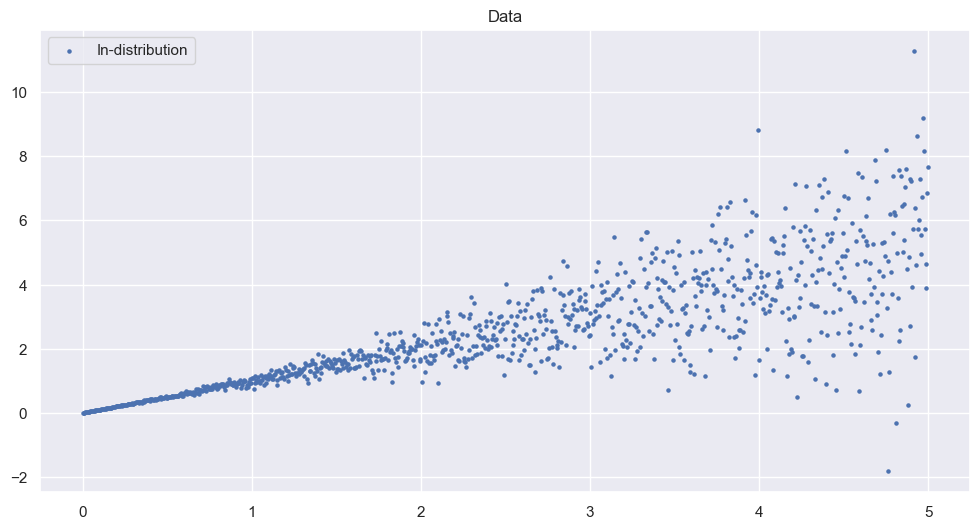

In [38]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

The function is linear with some Gaussian noise added to it that increases with the input value (cone shape).

In [39]:
# Make batch data 
def make_batch(data_size, sample_size, data_x, data_y):
    # Make batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, 1])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i]]
        batch_y[i,:] = data_y[batch_idx[i]] 
    
    batch_x = torch.FloatTensor(batch_x).to(device)
    batch_y = torch.FloatTensor(batch_y).to(device)
    
    return batch_x, batch_y  

## I. Bayes by Backprop

In [40]:
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, x):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape).to(device)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape).to(device)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()
        
        return F.linear(x, self.w, self.b)

In [41]:
class MLP_BBB(nn.Module):
    def __init__(self, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden1 = Linear_BBB(1, 32, prior_var=prior_var)
        self.hidden2 = Linear_BBB(32 , 32, prior_var=prior_var)
        self.out = Linear_BBB(32, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden1.log_prior + self.hidden2.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden1.log_post + self.hidden2.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0]).to(device)   # 이거를 to(device 안했더니 에러 났음. 왜?)
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss

Setup some training parameters:

In [43]:
model = MLP_BBB().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1, betas=(0.9, 0.999))

Training loop:

In [44]:
for i in tqdm.tqdm(range(2_000)):
    model.train()
    optimizer.zero_grad()
    
    # create a batch
    batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
    
    # forward pass
    preds = model(batch_x)
    
    # calculate loss
    loss = model.sample_elbo(batch_x, batch_y, 10)
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # print loss
    if i % 100 == 0:
        print("Epoch: {0}, Loss: {1}".format(i, loss.item()))

  0%|          | 1/2000 [00:00<22:01,  1.51it/s]

Epoch: 0, Loss: 50790.2890625


  5%|▌         | 101/2000 [00:57<17:56,  1.76it/s]

Epoch: 100, Loss: 1615.3712158203125


 10%|█         | 201/2000 [01:54<16:49,  1.78it/s]

Epoch: 200, Loss: 411.96197509765625


 15%|█▌        | 301/2000 [02:50<15:48,  1.79it/s]

Epoch: 300, Loss: 415.0763244628906


 20%|██        | 401/2000 [03:47<15:20,  1.74it/s]

Epoch: 400, Loss: 271.9183044433594


 25%|██▌       | 501/2000 [04:39<12:49,  1.95it/s]

Epoch: 500, Loss: 434.2764892578125


 30%|███       | 601/2000 [05:32<12:09,  1.92it/s]

Epoch: 600, Loss: 174.76133728027344


 35%|███▌      | 701/2000 [06:25<11:47,  1.84it/s]

Epoch: 700, Loss: 235.77914428710938


 40%|████      | 801/2000 [07:18<10:26,  1.91it/s]

Epoch: 800, Loss: 133.86209106445312


 45%|████▌     | 901/2000 [08:11<09:23,  1.95it/s]

Epoch: 900, Loss: 454.0104064941406


 50%|█████     | 1001/2000 [09:03<08:41,  1.92it/s]

Epoch: 1000, Loss: 297.8800048828125


 55%|█████▌    | 1101/2000 [09:56<07:48,  1.92it/s]

Epoch: 1100, Loss: 213.25625610351562


 60%|██████    | 1201/2000 [10:48<07:09,  1.86it/s]

Epoch: 1200, Loss: 160.17343139648438


 65%|██████▌   | 1301/2000 [11:43<06:34,  1.77it/s]

Epoch: 1300, Loss: 185.82269287109375


 70%|███████   | 1401/2000 [12:40<05:24,  1.85it/s]

Epoch: 1400, Loss: 112.71273040771484


 75%|███████▌  | 1501/2000 [13:36<04:41,  1.77it/s]

Epoch: 1500, Loss: 80.99022674560547


 80%|████████  | 1601/2000 [14:33<03:47,  1.76it/s]

Epoch: 1600, Loss: 231.04299926757812


 85%|████████▌ | 1701/2000 [15:29<02:49,  1.77it/s]

Epoch: 1700, Loss: 95.19668579101562


 90%|█████████ | 1801/2000 [16:24<01:43,  1.91it/s]

Epoch: 1800, Loss: 122.51075744628906


 95%|█████████▌| 1901/2000 [17:16<00:52,  1.90it/s]

Epoch: 1900, Loss: 252.7715606689453


100%|██████████| 2000/2000 [18:08<00:00,  1.84it/s]


Function that estimates the uncertainty:

In [45]:
def uncertainity_estimate(x, model, num_samples):
    outputs = np.hstack([model(x).cpu().detach().numpy() for i in range(num_samples)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    y_std = np.sqrt(y_variance)
    return outputs, y_mean, y_std

In [46]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

In [47]:
iters_uncertainty = 200

n_std = 2 # number of standard deviations to plot
outputs, y_mean, y_std = uncertainity_estimate(X_sample_tensor, model, iters_uncertainty)

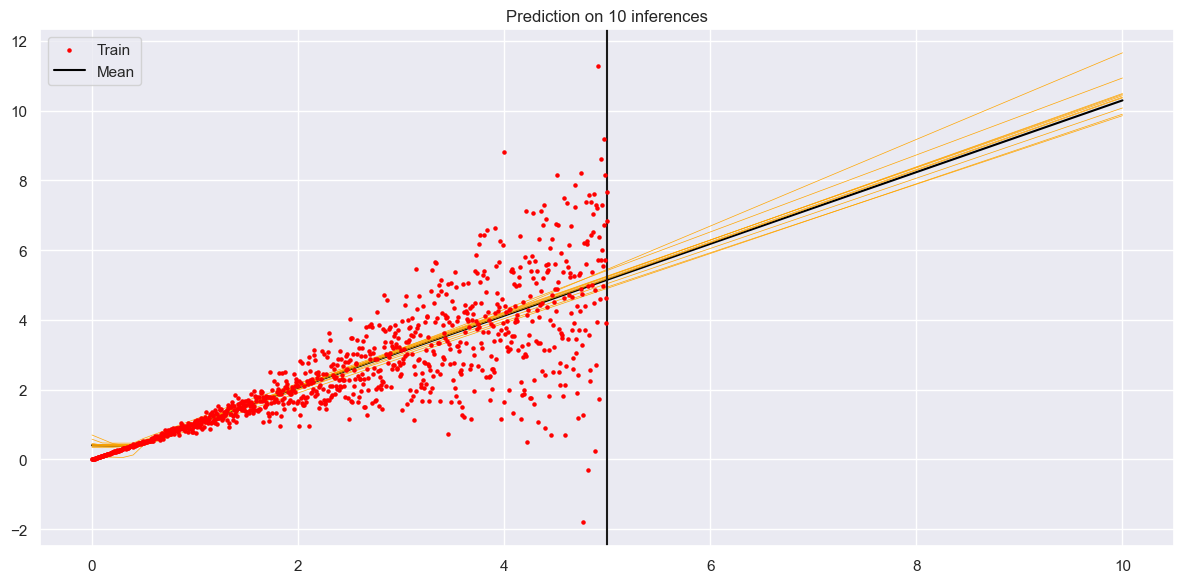

In [48]:
# plot
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
# plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")

for i in range(10):
    plt.plot(x_sample, outputs[:, i], color="orange", linewidth=0.5)

plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction on 10 inferences')
plt.tight_layout()
plt.show()

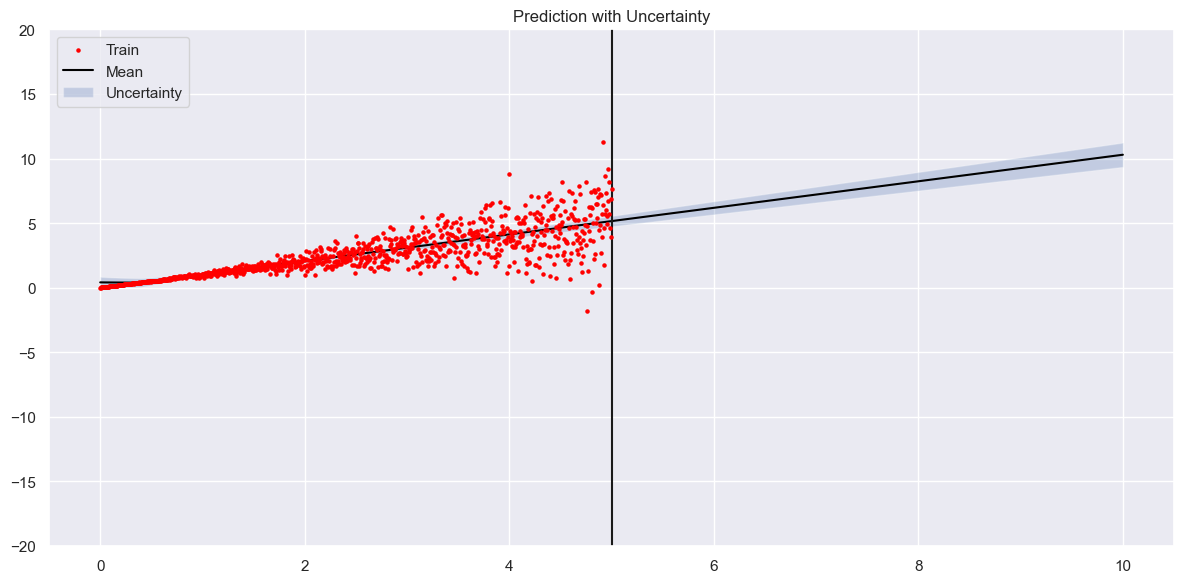

In [49]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

In [50]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

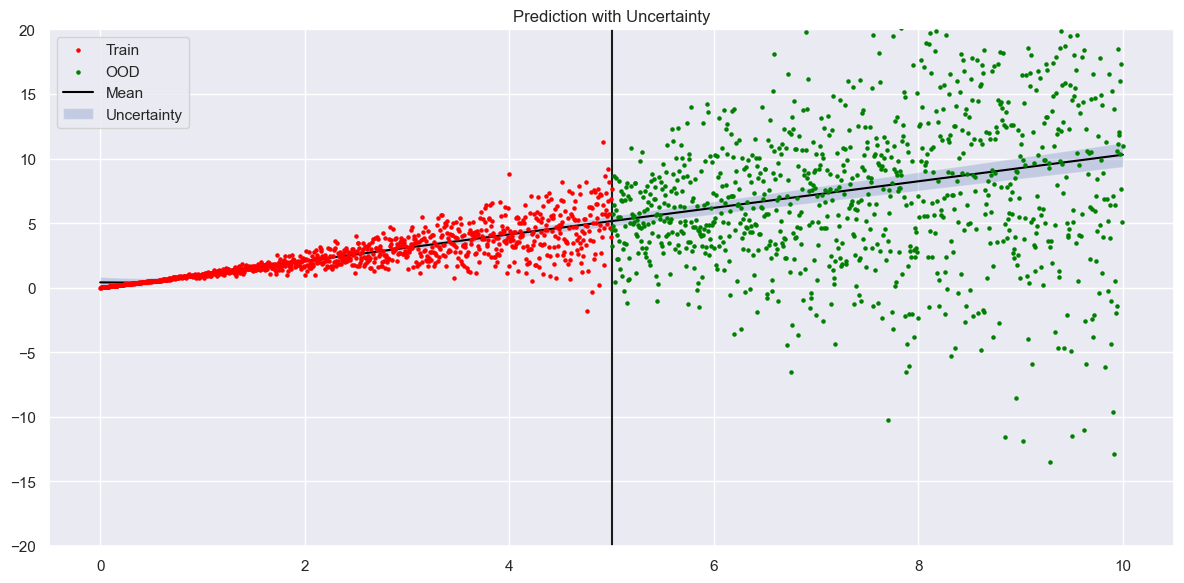

In [51]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()